In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

### input an image

(256, 256, 3)


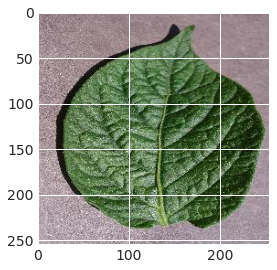

In [37]:
fpath=r'../input/plantdisease/PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'
img=plt.imread(fpath)
print (img.shape)
imshow(img)


###  iterate through the data directory and create a data frame of the form filepaths, labels

In [38]:
sdir=r'../input/plantdisease/PlantVillage'
classlist=os.listdir(sdir)    
filepaths=[]
labels=[]    
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)        
            filepaths.append(fpath)
            labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print (df.head())
print('df length: ', len(df))
print (df['labels'].value_counts())

                                           filepaths  \
0  ../input/plantdisease/PlantVillage/Pepper__bel...   
1  ../input/plantdisease/PlantVillage/Pepper__bel...   
2  ../input/plantdisease/PlantVillage/Pepper__bel...   
3  ../input/plantdisease/PlantVillage/Pepper__bel...   
4  ../input/plantdisease/PlantVillage/Pepper__bel...   

                          labels  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  
df length:  20639
Tomato__Tomato_YellowLeaf__Curl_Virus          3209
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Potato___Early_blig

### this is a very unbalanced data set for df,  limit  maximum number of samples in a class to 500

In [39]:
sample_list=[]
max_size= 500
groups=df.groupby('labels')
for label in df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))     
print (df['labels'].value_counts())     
        

7025
Tomato_Late_blight                             500
Tomato__Tomato_YellowLeaf__Curl_Virus          500
Tomato_Early_blight                            500
Potato___Early_blight                          500
Tomato_Leaf_Mold                               500
Potato___Late_blight                           500
Tomato_healthy                                 500
Tomato_Septoria_leaf_spot                      500
Pepper__bell___Bacterial_spot                  500
Tomato__Target_Spot                            500
Pepper__bell___healthy                         500
Tomato_Bacterial_spot                          500
Tomato_Spider_mites_Two_spotted_spider_mite    500
Tomato__Tomato_mosaic_virus                    373
Potato___healthy                               152
Name: labels, dtype: int64


### To balance the dataset we will create augmented images for classes with less than 370 samples
### first create directories to hold the augmented images

In [40]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['Pepper__bell___Bacterial_spot', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Potato___Early_blight', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot']


### create augmented images and store in the aug directories


In [41]:
target=500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 152 validated image filenames.
Found 373 validated image filenames.


In [42]:
aug=r'./aug'
auglist=os.listdir(aug)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('klass: ', klass, '  file count: ', len(flist))

klass:  Pepper__bell___Bacterial_spot   file count:  0
klass:  Tomato__Target_Spot   file count:  0
klass:  Tomato_Leaf_Mold   file count:  0
klass:  Tomato_Spider_mites_Two_spotted_spider_mite   file count:  0
klass:  Tomato__Tomato_YellowLeaf__Curl_Virus   file count:  0
klass:  Tomato__Tomato_mosaic_virus   file count:  127
klass:  Potato___healthy   file count:  348
klass:  Tomato_healthy   file count:  0
klass:  Potato___Late_blight   file count:  0
klass:  Tomato_Late_blight   file count:  0
klass:  Tomato_Septoria_leaf_spot   file count:  0
klass:  Tomato_Early_blight   file count:  0
klass:  Potato___Early_blight   file count:  0
klass:  Pepper__bell___healthy   file count:  0
klass:  Tomato_Bacterial_spot   file count:  0


### look at some augmented images

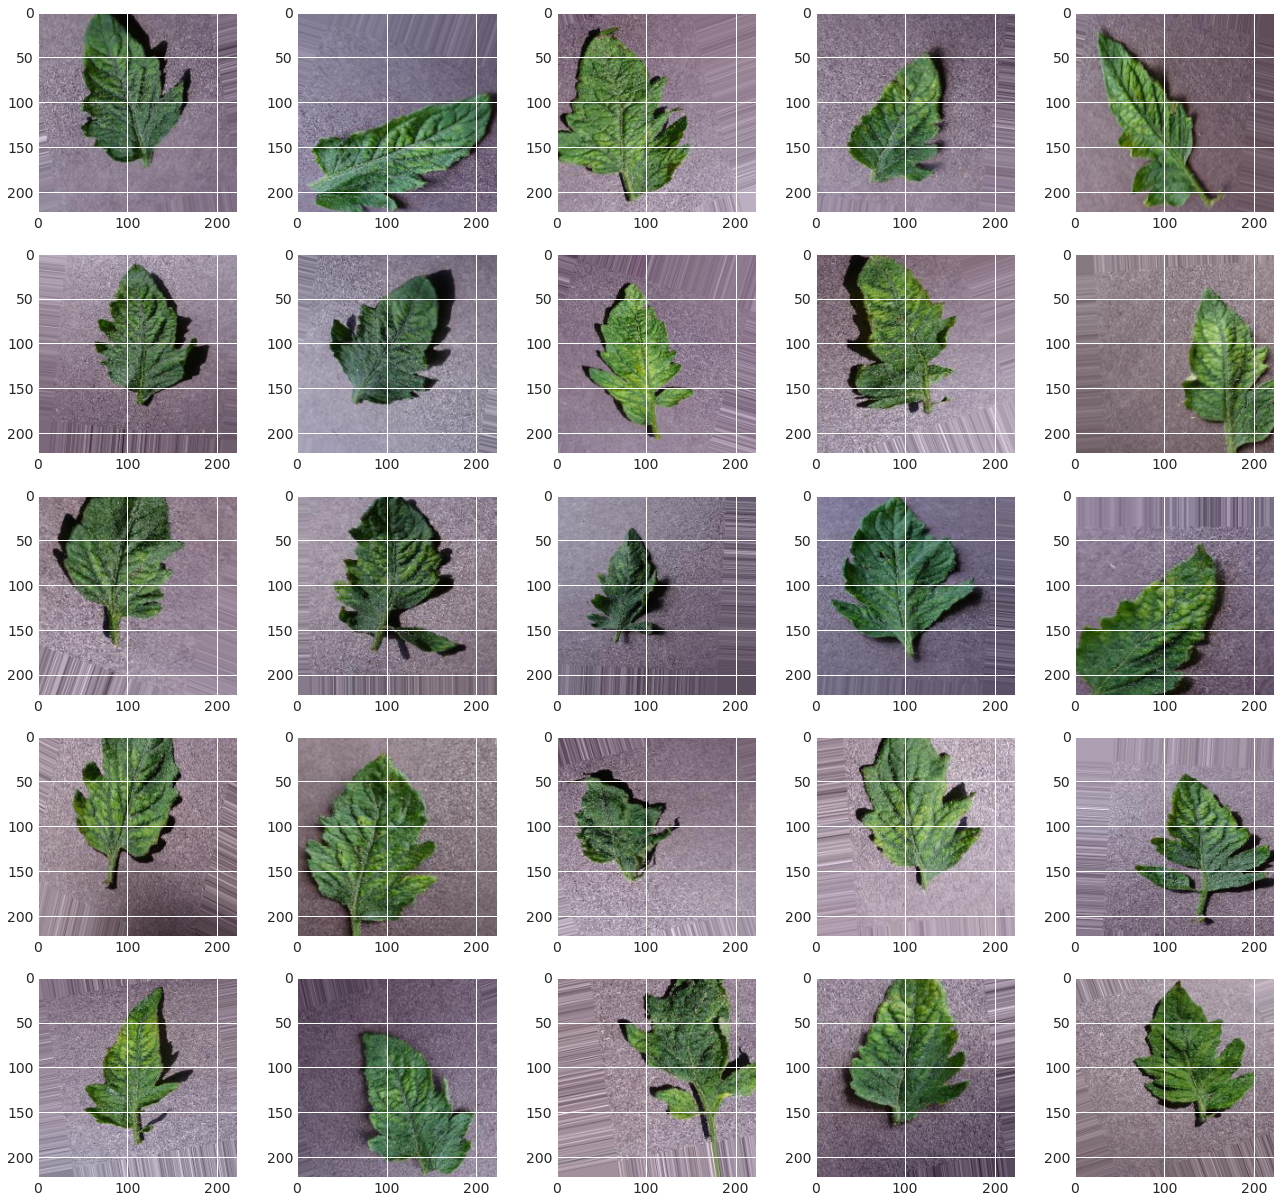

In [43]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image=next(aug_gen)/255
    image=np.squeeze(image, axis=0)
    plt.subplot(5,5,i+1)
    plt.imshow(image)
plt.show()
            

### Create the aux_df then concatenate with df 

In [44]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#ndf=df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)


print (df['labels'].value_counts()) 
print(aug_df['labels'].value_counts())
print (ndf['labels'].value_counts()) 

Tomato_Late_blight                             500
Tomato__Tomato_YellowLeaf__Curl_Virus          500
Tomato_Early_blight                            500
Potato___Early_blight                          500
Tomato_Leaf_Mold                               500
Potato___Late_blight                           500
Tomato_healthy                                 500
Tomato_Septoria_leaf_spot                      500
Pepper__bell___Bacterial_spot                  500
Tomato__Target_Spot                            500
Pepper__bell___healthy                         500
Tomato_Bacterial_spot                          500
Tomato_Spider_mites_Two_spotted_spider_mite    500
Tomato__Tomato_mosaic_virus                    373
Potato___healthy                               152
Name: labels, dtype: int64
Potato___healthy               348
Tomato__Tomato_mosaic_virus    152
Name: labels, dtype: int64
Tomato__Tomato_mosaic_virus                    525
Potato___healthy                               500
Tomato_La

###  now all classes in df have the target number of samples
### split df into train_df and valid_df

In [45]:
train_split=.8
valid_split=.1
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  6020   test_df length:  753   valid_df length:  752


### create train, test, valid  generators

In [46]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
sdir=r'../input/mars-surface-and-curiosity-image-set-nasa/Mars Surface and Curiosity Image/images'
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  3   test steps:  251
Found 6020 validated image filenames belonging to 15 classes.
Found 753 validated image filenames belonging to 15 classes.
Found 752 validated image filenames belonging to 15 classes.


### create function to show some image examples

In [47]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=10)
        plt.axis('off')
    plt.show()

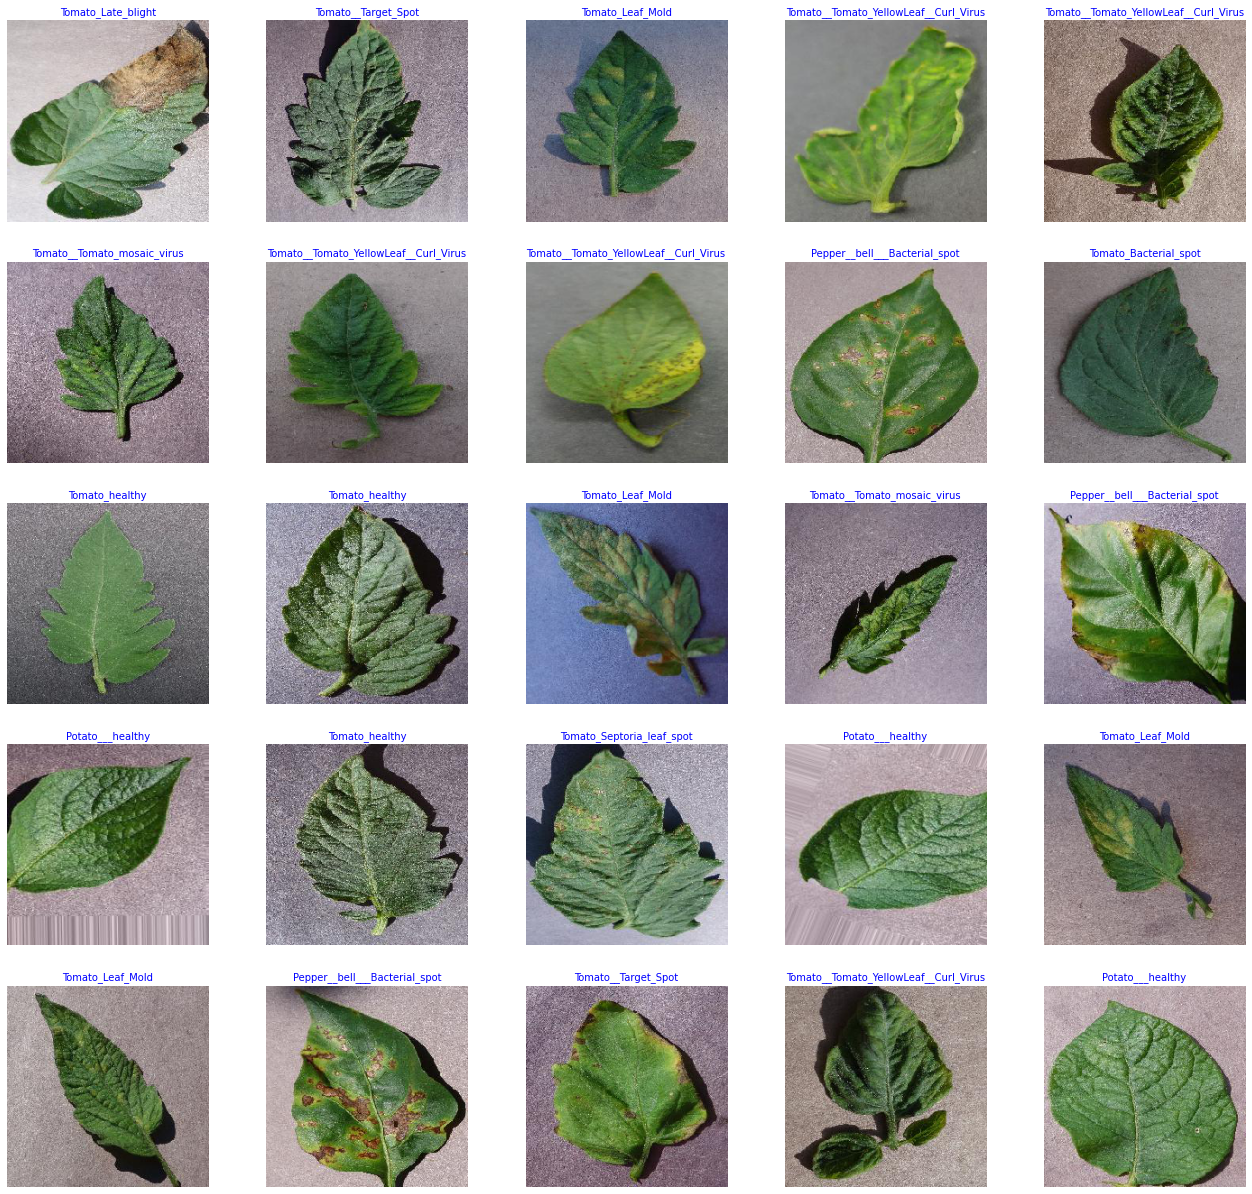

In [48]:
show_image_samples(train_gen)

### define function to print text in RGB foreground and background colors

In [49]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### create the model

In [50]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

### create a subclass of callbacks to control learning rate and print training results for each epoch

In [51]:
  class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                           
                   

### instantiate the custom callback and train the model

In [52]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /40     7.098   77.791   5.59940  90.824   0.00100  0.00100  accuracy   103.73 

 2 /40     4.428   95.017   3.54726  95.745   0.00100  0.00100  val_loss   91.78  

 3 /40     2.894   98.040   2.29125  98.271   0.00100  0.00100  val_loss   91.94  

 4 /40     1.898   98.721   1.49150  98.670   0.00100  0.00100  val_loss   91.62  

 5 /40     1.259   98.887   0.98720  98.803   0.00100  0.00100  val_loss   91.39  

 6 /40     0.858   99.086   0.68519  98.936   0.00100  0.00100  val_loss   91.19  

 7 /40     0.619   99.319   0.50532  98.803   0.00100  0.00100  val_loss   91.02  

 8 /40     0.477   99.635   0.41398  98.803   0.00100  0.00100  val_loss   91.45  

 9 /40     0.392   99.684   0.33717  99.468   0.00100  0.00100  val_loss   91.31  

10 /40     0.343   99.635   0.30586  99.202   0.00100  0.00100  val_loss   90.90  

ente

 H


training has been halted at epoch 10 due to user input

Training is completed - model is set with weights for the epoch with the lowest loss



### define function to plot the training data

In [53]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [54]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

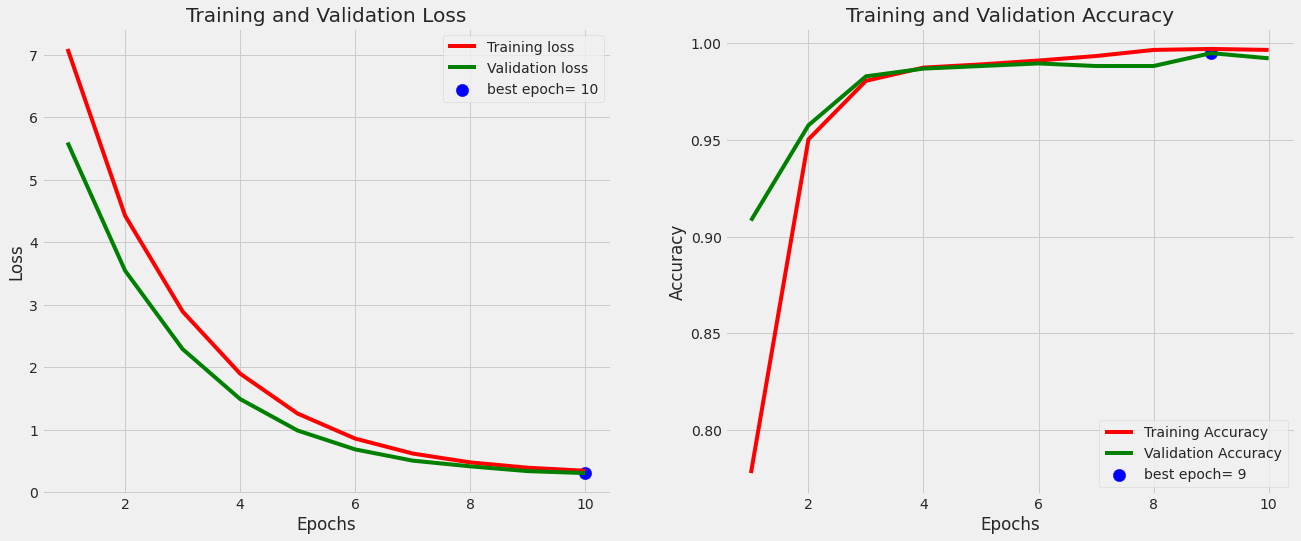

251/251 [==============================] - 4s 16ms/step - loss: 0.3224 - accuracy: 0.9880
accuracy on the test set is 98.80 %



In [55]:
tr_plot(history,0)
save_dir=r'./'
subject='plants'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

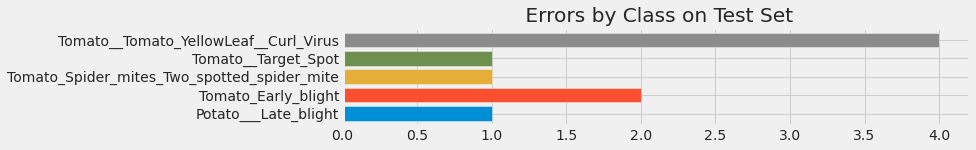

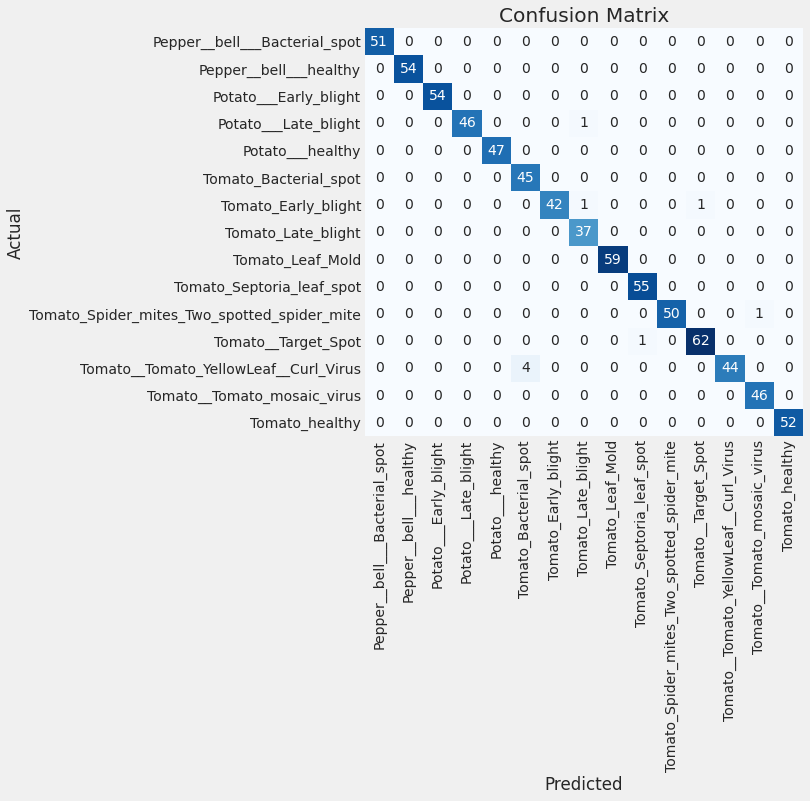

Classification Report:
----------------------
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        51
                     Pepper__bell___healthy       1.00      1.00      1.00        54
                      Potato___Early_blight       1.00      1.00      1.00        54
                       Potato___Late_blight       1.00      0.98      0.99        47
                           Potato___healthy       1.00      1.00      1.00        47
                      Tomato_Bacterial_spot       0.92      1.00      0.96        45
                        Tomato_Early_blight       1.00      0.95      0.98        44
                         Tomato_Late_blight       0.95      1.00      0.97        37
                           Tomato_Leaf_Mold       1.00      1.00      1.00        59
                  Tomato_Septoria_leaf_spot       0.98      1.00      0.99        55
Tomato_Spider_mit

In [56]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

### some viewers have asked how to use the trained model to predict a single image
### the code below demonstrates that using a Pepper__bell___Bacterial_spot image

Input image shape is  (256, 256, 3)
the resized image has shape  (224, 224, 3)
image shape after expanding dimensions is  (1, 224, 224, 3)
 the shape of prediction is  (1, 15)
the image is predicted as being  Pepper__bell___Bacterial_spot  with a probability of  99.48790073394775


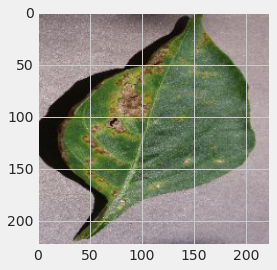

In [57]:
fpath=r'../input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG'
img=plt.imread(fpath)
print ('Input image shape is ', img.shape)
# resize the image so it is the same size as the images the model was trained on
img=cv2.resize(img, img_size) # in earlier code img_size=(224,224) was used for training the model
print ('the resized image has shape ', img.shape)
### show the resized image
plt.imshow(img)
# Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
# img= img/255
# plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
# since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
# where the first dimension 1 is the batch size used by model.predict
img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
# now predict the image
pred=model.predict(img)
print (' the shape of prediction is ', pred.shape)
# this dataset has 15 classes so model.predict will return a list of 15 probability values
# we want to find the index of the column that has the highest probability
index=np.argmax(pred[0])
# to get the actual Name of the class earlier Imade a list of the class names called classes
klass=classes[index]
# lets get the value of the highest probability
probability=pred[0][index]*100
# print out the class, and the probability 
print('the image is predicted as being ', klass, ' with a probability of ', probability)


### As you can see the prediction is correct

In [58]:
### if you want to predict on several images the code is very similar. Lets make a directory and store 2 image files in it
### one will be the image we used above. The second will be an image of a tomato leaf with Target_spot disease

In [59]:
working_dir = r'./' # kagle working directory
# in the working directory create a sub directory called test_images
dir_path=os.path.join(working_dir, 'test_images')
if os.path.isdir(dir_path): # check if the directory exists, if it does remove it and all its content
    shutil.rmtree(dir_path)
os.mkdir(dir_path) # make a new empty directory
img1_path=r'../input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG'
img2_path = r'../input/plantdisease/PlantVillage/Tomato__Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG'
img1_destination=os.path.join(dir_path,'img1.jpg')
shutil.copy(img1_path, img1_destination)
img2_destination=os.path.join(dir_path, 'img2.jpg')
shutil.copy(img2_path, img2_destination)
# check if the files are there
files = os.listdir(dir_path)
print (files)            
            


['img2.jpg', 'img1.jpg']


### so we have 2 files in a directory that we want to predict
### the code for that is shown below

In [60]:
images=[]
file_list=os.listdir(dir_path)
for f in file_list:
    fpath=os.path.join(dir_path,f)
    img=plt.imread(fpath)
    img=cv2.resize(img, img_size)
    images.append(img)
img_array=np.array(images)
print (' shape of the image array is ',img_array.shape)
preds=model.predict(img_array)
print('shape of preds is ', preds.shape)
fi='FILE'
ci='CLASS'
pi='PROBABILITY'
print(f'{fi:^10s} {ci:^35s} {pi:^10s}')
for i, p in enumerate(preds):
    index=np.argmax(p)
    klass=classes[index]    
    probability=p[index]*100
    file=file_list[i]
    print (f'{file:^10s}{klass:^35s}  {probability:^10.2f}')
    

    

 shape of the image array is  (2, 224, 224, 3)
shape of preds is  (2, 15)
   FILE                   CLASS                PROBABILITY
 img2.jpg         Tomato__Target_Spot            91.21   
 img1.jpg    Pepper__bell___Bacterial_spot       99.49   
